In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfd
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam

# Data Preparation
### Load dataset from tensorflow datasets

In [ ]:
dataset, dataset_info = tfd.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

In [ ]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear i

In [ ]:
for data in dataset['train'].take(1):
  print(data)

{'image': <tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=1>}


### split dataset

In [ ]:
def split(dataset, train_ratio, test_ratio, val_ratio):
  dataset = dataset
  dataset_size = len(dataset)
  train_dataset = dataset.take(int(train_ratio * dataset_size))

  val_test_dataset = dataset.skip(int(test_ratio * dataset_size))
  val_dataset = dataset.take(int(val_ratio * dataset_size))

  test_dataset = dataset.skip(int(test_ratio * dataset_size))

  return train_dataset, test_dataset, val_dataset


In [ ]:
train_data, test_data, val_data = split(dataset[0], 0.8, 0.1, 0.1)

In [ ]:
print(list(train_data.take(1).as_numpy_iterator()), list(test_data.take(1).as_numpy_iterator()), list(val_data.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

# Data Visualization

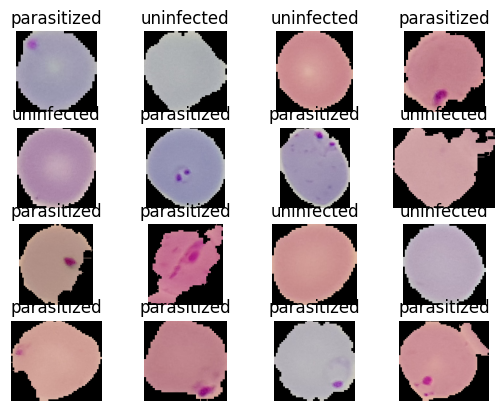

In [ ]:
for i, (image, label) in enumerate(train_data.take(16)):
  ax = plt.subplot(4,4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

# Data Preprocessing

## Resize

In [ ]:
IM_SIZE = 224
def resizing(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE)), label

In [ ]:
train_data = train_data.map(resizing)

In [ ]:
for image, label in train_data.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
val_data = val_data.map(resizing)


In [ ]:
test_data = test_data.map(resizing)

## Normalization

In [ ]:
def rescale(image, label):
  return image/255.0, label

In [ ]:
train_data = train_data.map(rescale)
val_data = val_data.map(rescale)

test_data=val_data.map(rescale)

In [ ]:
train_data = train_data.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_data = val_data.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Model Creation

In [ ]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE,3)),
    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2, ),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2, ),

    Flatten(),

    Dense(100, activation='relu'),
    BatchNormalization(),

    Dense(10, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='sigmoid'),
]

)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                      

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.01),
               loss = BinaryCrossentropy(),
               metrics = 'accuracy')

In [ ]:
history = model.fit(train_data, validation_data=val_data, epochs=20, verbose=1)

Epoch 1/20
689/689 [==============================] - 39s 57ms/step - loss: 0.1617 - accuracy: 0.9470 - val_loss: 0.1150 - val_accuracy: 0.9626
Epoch 2/20
689/689 [==============================] - 39s 56ms/step - loss: 0.1404 - accuracy: 0.9535 - val_loss: 0.1119 - val_accuracy: 0.9568
Epoch 3/20
689/689 [==============================] - 36s 53ms/step - loss: 0.1328 - accuracy: 0.9559 - val_loss: 0.0949 - val_accuracy: 0.9691
Epoch 4/20
689/689 [==============================] - 40s 58ms/step - loss: 0.1248 - accuracy: 0.9584 - val_loss: 0.7509 - val_accuracy: 0.9550
Epoch 5/20
689/689 [==============================] - 40s 58ms/step - loss: 0.1116 - accuracy: 0.9639 - val_loss: 0.1875 - val_accuracy: 0.9702
Epoch 6/20
689/689 [==============================] - 56s 82ms/step - loss: 0.1034 - accuracy: 0.9659 - val_loss: 0.0675 - val_accuracy: 0.9775
Epoch 7/20
689/689 [==============================] - 50s 73ms/step - loss: 0.0731 - accuracy: 0.9754 - val_loss: 0.0850 - val_accuracy:

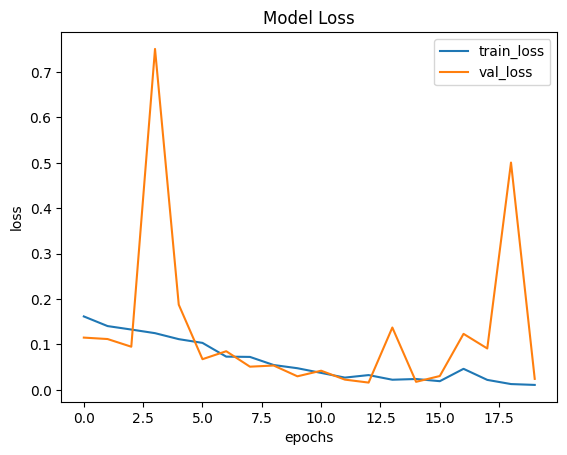

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show()

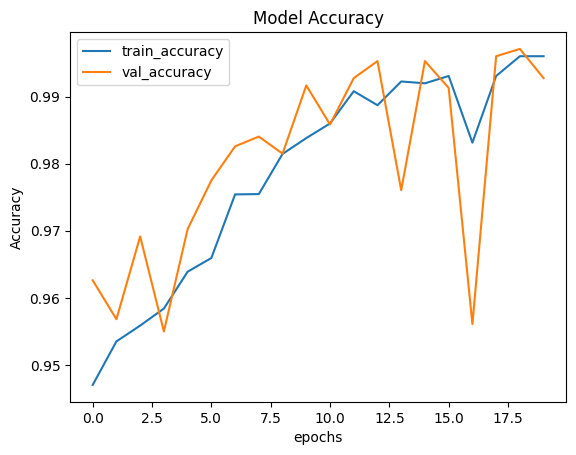

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation

In [ ]:
test_data = test_data.batch(1)

In [ ]:
model.evaluate(test_data)

2755/2755 [==============================] - 12s 4ms/step - loss: 3.1771 - accuracy: 0.4817


[3.1770668029785156, 0.48166969418525696]

In [ ]:
def parasite_or_not(x):
  if (x<0.5):
    return str('P')
  else:
    return str('U')


1/1 [==============================] - 0s 18ms/step


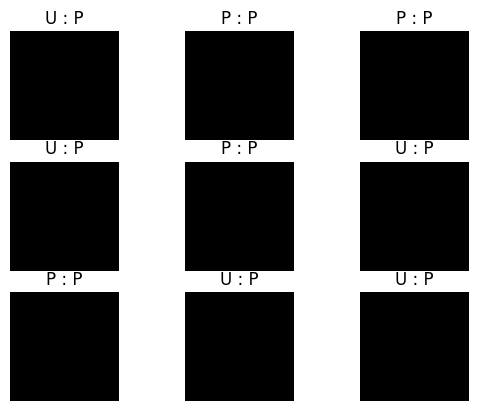

In [ ]:
for i, (image, label) in enumerate(test_data.take(9)):
  ax = plt.subplot(3,3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0]))+" : "+str(parasite_or_not(model.predict(image)[0][0])))
  plt.axis('off')